In [1]:
import pandas as pd
import common_functions as cf
import matplotlib.pyplot as plt
import numpy as np

# CCS

In [2]:
ccs = pd.read_excel('../data/targets/Pancreatic Cancer SEER Rates.xlsx', sheet_name='Cause-specific survival_stage').iloc[2:87,[0,3,4,5,6,7,8,9,10,11,12]]
ccs.columns = ['age','t1n','t1','t2n','t2','t3n','t3','t4n','t4','ukn','unknown']

In [3]:
ccs

,age,t1n,t1,t2n,t2,t3n,t3,t4n,t4,ukn,unknown
2,00 years,0,+,1,1,0,+,0,+,4,1
3,01 years,0,+,0,+,0,+,0,+,2,1
4,02 years,0,+,0,+,0,+,0,+,1,+
5,03 years,0,+,0,+,0,+,0,+,0,+
6,04 years,0,+,1,+,3,0.333,0,+,2,0
...,...,...,...,...,...,...,...,...,...,...,...
82,80 years,64,0.215,357,0.072,662,0.044,272,0.026,1509,0.048
83,81 years,61,0.199,317,0.03,649,0.048,245,0.018,1454,0.049
84,82 years,53,0.165,358,0.04,596,0.074,226,0,1384,0.051
85,83 years,35,0.234,300,0.032,503,0.034,221,0.008,1126,0.047


In [4]:
ccs['age'] = list(range(0,85))

In [5]:
ccs = ccs.iloc[18:,:]

In [6]:
ccs = ccs.replace('+',0)
ccs = ccs.replace(0, 1)

In [7]:
ccs = ccs.reset_index(drop=True)

In [8]:
t1nT = np.array(ccs['t1n'])/np.array(ccs['t1'])
t2nT = np.array(ccs['t2n'])/np.array(ccs['t2'])
t3nT = np.array(ccs['t3n'])/np.array(ccs['t3'])
t4nT = np.array(ccs['t4n'])/np.array(ccs['t4'])
uknT = np.array(ccs['ukn'])/np.array(ccs['unknown'])

In [9]:
ccs['t1nT'] = t1nT
ccs['t2nT'] = t2nT
ccs['t3nT'] = t3nT
ccs['t4nT'] = t4nT
ccs['uknT'] = uknT

In [10]:
new_row = {}
for i, row in ccs.iterrows():
    addT = np.array(row['t1nT':'t4nT'])/row['t1nT':'t4nT'].sum()*row['uknT']
    add_cases = np.array(row[['t1n','t2n','t3n','t4n']])/row[['t1n','t2n','t3n','t4n']].sum()*row['ukn']
    cases = np.array(row[['t1n','t2n','t3n','t4n']]) + add_cases
    total = np.array(row['t1nT':'t4nT']) + addT

    new_row[row['age']] = (cases/total)

merged_ccs = pd.DataFrame.from_dict(new_row, orient = 'index')
merged_ccs.columns = ['t1', 't2', 't3', 't4']

In [11]:
merged_ccs

,t1,t2,t3,t4
18.0,0.909941,0.796198,0.909941,0.909941
19.0,1.106178,1.106178,0.368357,1.106178
20.0,1.101013,1.101013,0.366637,1.101013
21.0,0.749269,0.624141,0.374634,0.749269
22.0,1.136362,0.973862,0.378409,1.136362
...,...,...,...,...
80.0,0.224754,0.075266,0.045996,0.027180
81.0,0.239487,0.036104,0.057766,0.021662
82.0,0.137543,0.033344,0.061686,0.833591
83.0,0.330412,0.045185,0.048009,0.011296


In [12]:
css2mort = []
for i, row in merged_ccs.iterrows():
    newrow = []
    for ii in row:
        newrow.append(cf.rate_to_prob(cf.prob_to_rate(1-ii, 5),1))
    css2mort.append(newrow)
css2mort_df = pd.DataFrame(css2mort)
css2mort_df.columns = ['T1', 'T2', 'T3', 'T4']

In [13]:
css2mort_df

,T1,T2,T3,T4
0,0.018698,0.044558,0.018698,0.018698
1,0.019980,0.019980,0.181057,0.019980
2,0.019062,0.019062,0.181823,0.019062
3,0.056097,0.089968,0.178284,0.056097
4,0.025242,0.005283,0.176635,0.025242
...,...,...,...,...
62,0.258107,0.403899,0.459813,0.513763
63,0.248625,0.485352,0.434628,0.535334
64,0.327508,0.493473,0.427155,0.035748
65,0.198670,0.461733,0.455167,0.592070


In [14]:
css2mort_df['age']=list(range(18,85))

<AxesSubplot:xlabel='age'>

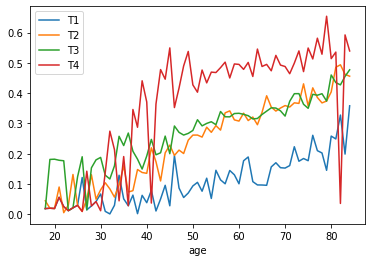

In [15]:
css2mort_df.plot(x='age')

# Smooth CSM

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [17]:
def func(x, a, b, c):
    return a * np.exp(b * x) + c

In [18]:
# define the true objective function
def objective(x, a, b, c):
    return a * x + b * x**2 + c

In [19]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

In [20]:
# ydata = css2mort_df['T1']

# p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
# # popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
# popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='trf')

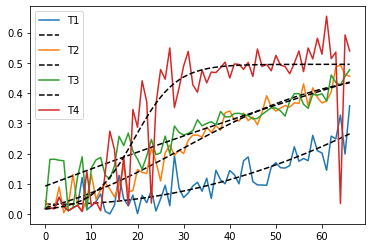

In [21]:
xdata = list(range(0,len(css2mort_df)))
smooth = {}
for i in ['T1', 'T2', 'T3', 'T4']:
    ydata = css2mort_df[i]
    try:
        p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
        # popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='lm')
        plt.plot(xdata, css2mort_df[i])
        plt.plot(xdata, sigmoid(np.array(xdata), float(popt[0]), float(popt[1]), float(popt[2]), float(popt[3])), 'k--')
        smooth[i] = sigmoid(np.array(xdata), float(popt[0]), float(popt[1]), float(popt[2]), float(popt[3]))
    except:
        popt, pcov = curve_fit(objective, xdata, ydata)
        plt.plot(xdata, css2mort_df[i])
        plt.plot(xdata, objective(np.array(xdata), float(popt[0]), float(popt[1]), float(popt[2])), 'k--')
        smooth[i] = objective(np.array(xdata), float(popt[0]), float(popt[1]), float(popt[2]))
plt.legend(['T1','','T2','','T3','','T4'])

In [22]:
def find_linear_interval(dat):
    idx_neg = -1
    for i in range(len(dat)):
        if dat[i]<0:
            idx_neg = i
    if idx_neg == -1:
        res = dat
    else:
        idx_pos = idx_neg + 1

        b = dat[idx_pos]*0.1
        y = dat[idx_pos]
        a = (y-b)/idx_pos

        lin_v = []
        for i in range(idx_pos):
            lin_v.append(a*i+b)
        res = np.array(lin_v+list(dat)[idx_pos:])
    return res

In [23]:
smooth_mod = {}
smooth_mod['T1'] = find_linear_interval(smooth['T1'])
smooth_mod['T2'] = find_linear_interval(smooth['T2'])
smooth_mod['T3'] = find_linear_interval(smooth['T3'])
smooth_mod['T4'] = find_linear_interval(smooth['T4'])

In [24]:
smooth_mod['T1']

array([0.03361779, 0.0333896 , 0.03327654, 0.03327863, 0.03339585,
       0.03362822, 0.03397572, 0.03443837, 0.03501615, 0.03570908,
       0.03651714, 0.03744035, 0.03847869, 0.03963218, 0.04090081,
       0.04228457, 0.04378348, 0.04539752, 0.04712671, 0.04897104,
       0.05093051, 0.05300511, 0.05519486, 0.05749975, 0.05991978,
       0.06245494, 0.06510525, 0.0678707 , 0.07075129, 0.07374702,
       0.07685788, 0.08008389, 0.08342504, 0.08688133, 0.09045276,
       0.09413933, 0.09794104, 0.10185789, 0.10588988, 0.11003701,
       0.11429928, 0.11867669, 0.12316924, 0.12777693, 0.13249976,
       0.13733773, 0.14229084, 0.14735909, 0.15254249, 0.15784102,
       0.16325469, 0.1687835 , 0.17442745, 0.18018655, 0.18606078,
       0.19205015, 0.19815466, 0.20437432, 0.21070911, 0.21715904,
       0.22372411, 0.23040433, 0.23719968, 0.24411018, 0.25113581,
       0.25827658, 0.2655325 ])

Text(0, 0.5, 'Cause Specific Mortality')

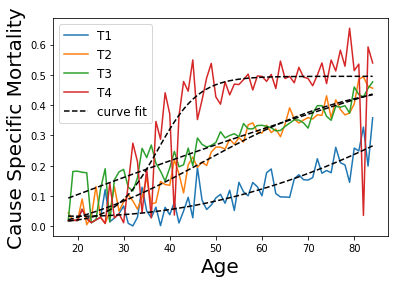

In [25]:
for i in ['T1', 'T2', 'T3', 'T4']:
    plt.plot(range(18,85), css2mort_df[i])
for i in ['T1', 'T2', 'T3', 'T4']:
    plt.plot(range(18,85), smooth_mod[i], 'k--') 
plt.legend(['T1','T2','T3','T4', 'curve fit'], fontsize = 12)
plt.xlabel('Age', fontsize = 20)
plt.ylabel('Cause Specific Mortality', fontsize = 20)

In [161]:
import pickle
with open('../data/targets/cancer_specific_mortality.pickle', 'wb') as handle:
    pickle.dump(smooth_mod, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [162]:
with open('../data/targets/cancer_specific_mortality.pickle', 'rb') as handle:
    m = pickle.load(handle)

In [163]:
m

{'T1': array([0.03361779, 0.0333896 , 0.03327654, 0.03327863, 0.03339585,
        0.03362822, 0.03397572, 0.03443837, 0.03501615, 0.03570908,
        0.03651714, 0.03744035, 0.03847869, 0.03963218, 0.04090081,
        0.04228457, 0.04378348, 0.04539752, 0.04712671, 0.04897104,
        0.05093051, 0.05300511, 0.05519486, 0.05749975, 0.05991978,
        0.06245494, 0.06510525, 0.0678707 , 0.07075129, 0.07374702,
        0.07685788, 0.08008389, 0.08342504, 0.08688133, 0.09045276,
        0.09413933, 0.09794104, 0.10185789, 0.10588988, 0.11003701,
        0.11429928, 0.11867669, 0.12316924, 0.12777693, 0.13249976,
        0.13733773, 0.14229084, 0.14735909, 0.15254249, 0.15784102,
        0.16325469, 0.1687835 , 0.17442745, 0.18018655, 0.18606078,
        0.19205015, 0.19815466, 0.20437432, 0.21070911, 0.21715904,
        0.22372411, 0.23040433, 0.23719968, 0.24411018, 0.25113581,
        0.25827658, 0.2655325 ]),
 'T2': array([0.02162698, 0.02574562, 0.03004089, 0.03451612, 0.03917426,
  